1.identify policy and explain about the policy ?explain the policy enforced
2.explain some more polices that is compatible with SARSA? list them?
3.enforce two policies in this code
4. tuning hyperparameters for better results

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [44]:

class TreasureHunterSARSA:

    def __init__(self, grid_size=5, alpha=0.1, gamma=0.9, epsilon=0.1, ucb_c=1.0):
        """
        Initialize the Treasure Hunter
        Args:
            grid_size: Size of the grid world (grid_size x grid_size)
            alpha: Learning rate
            gamma: Discount factor
            epsilon: Exploration rate
            ucb_c: UCB exploration constant
        """
        self.size = grid_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.ucb_c = ucb_c

        # Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        self.actions = ['UP', 'RIGHT', 'DOWN', 'LEFT']
        self.action_effects = [(-1, 0), (0, 1), (1, 0), (0, -1)]

        # Q-table and N-table (for UCB)
        self.Q = defaultdict(lambda: np.zeros(4))
        self.N = defaultdict(lambda: np.zeros(4))

        # Game setup
        self.start_pos = (grid_size - 1, 0)
        self.treasure_pos = (0, grid_size - 1)
        self.traps = [(1, 1), (2, 3), (3, 2)]

        # Track learning
        self.episode_rewards = []
        self.episode_steps = []

    def get_state_key(self, pos):
        return f"{pos[0]},{pos[1]}"

    def is_valid_position(self, pos):
        row, col = pos
        return 0 <= row < self.size and 0 <= col < self.size

    def get_reward(self, pos):
        if pos == self.treasure_pos:
            return 100
        elif pos in self.traps:
            return -50
        else:
            return -1

    def take_action(self, pos, action):
        row, col = pos
        d_row, d_col = self.action_effects[action]
        new_pos = (row + d_row, col + d_col)
        if not self.is_valid_position(new_pos):
            new_pos = pos
        reward = self.get_reward(new_pos)
        return new_pos, reward

    # Policy methods
    def choose_action_ucb(self, state_key, total_steps):
        q_values = self.Q[state_key]
        counts = self.N[state_key]
        total_counts = np.sum(counts) + 1e-5
        ucb_values = q_values + self.ucb_c * np.sqrt(np.log(total_steps + 1) / (counts + 1e-5))
        action = np.argmax(ucb_values)
        return action

    def choose_action_rank_based(self, state_key,alpha=1.5):
        q_values = self.Q[state_key]
        ranks = np.argsort(np.argsort(-q_values)) + 1  # Rank 1 is best
        weights = np.exp(-alpha * (ranks - 1))         # Exponential decay from best rank
        probabilities = weights / weights.sum()
        return np.random.choice(len(q_values), p=probabilities)

        
    def choose_action_epsilon_greedy(self, state_key, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon
        if np.random.random() < epsilon:
            return np.random.choice(4)
        else:
            return np.argmax(self.Q[state_key])

    def choose_action_boltzmann(self, state_key, temperature=1.0):
        q_values = self.Q[state_key]
        exp_values = np.exp((q_values - np.max(q_values)) / temperature)
        probabilities = exp_values / np.sum(exp_values)
        return np.random.choice(4, p=probabilities)

    def choose_action_greedy(self, state_key):
        return np.argmax(self.Q[state_key])

    def choose_action(self, state_key, policy='epsilon_greedy', total_steps=None):
        if policy == 'epsilon_greedy':
            return self.choose_action_epsilon_greedy(state_key)
        elif policy == 'boltzmann':
            return self.choose_action_boltzmann(state_key)
        elif policy == 'greedy':
            return self.choose_action_greedy(state_key)
        elif policy == 'ucb':
            if total_steps is None:
                raise ValueError("total_steps must be provided for UCB policy")
            return self.choose_action_ucb(state_key, total_steps)
        elif policy == 'rank':
            return self.choose_action_rank_based(state_key)
        else:
            raise ValueError(f"Unknown policy: {policy}")

    # Run a single episode
    def run_episode(self, policy='epsilon_greedy', max_steps=100, total_steps=0):
        current_pos = self.start_pos
        state_key = self.get_state_key(current_pos)
        action = self.choose_action(state_key, policy, total_steps)
        total_reward = 0
        steps = 0
        path = [current_pos]

        while steps < max_steps:
            next_pos, reward = self.take_action(current_pos, action)
            next_key = self.get_state_key(next_pos)
            next_action = self.choose_action(next_key, policy, total_steps)

            # SARSA update
            self.Q[state_key][action] += self.alpha * (
                reward + self.gamma * self.Q[next_key][next_action] - self.Q[state_key][action]
            )

            # Increment N-table for UCB
            self.N[state_key][action] += 1

            total_reward += reward
            steps += 1
            path.append(next_pos)

            if next_pos == self.treasure_pos or next_pos in self.traps:
                break

            current_pos, state_key, action = next_pos, next_key, next_action
            total_steps += 1

        return total_reward, steps, path

    # Training
    def train(self, episodes=1000, policy='epsilon_greedy', verbose=True):
        self.episode_rewards = []
        self.episode_steps = []
        total_steps = 0

        for ep in range(episodes):
            reward, steps, _ = self.run_episode(policy, total_steps=total_steps)
            self.episode_rewards.append(reward)
            self.episode_steps.append(steps)
            total_steps += steps
            if policy == 'epsilon_greedy' and ep % 100 == 0:
                self.epsilon *= 0.95

            if verbose and (ep + 1) % 200 == 0:
                print(f"Episode {ep + 1}: Avg Reward = {np.mean(self.episode_rewards[-100:]):.2f}, "
                      f"Avg Steps = {np.mean(self.episode_steps[-100:]):.2f}, ε = {self.epsilon:.3f}")

    # Testing
    def test_policy(self, policy='greedy', num_tests=5):
        original_epsilon = self.epsilon
        results = []
        for _ in range(num_tests):
            if policy == 'greedy':
                self.epsilon = 0
            reward, steps, path = self.run_episode(policy)
            results.append((reward, steps, path))
        self.epsilon = original_epsilon
        return results

    # Visualization
    def visualize_grid(self, path=None, title="Treasure Hunter Grid"):
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        grid = np.zeros((self.size, self.size))
        grid[self.start_pos[0], self.start_pos[1]] = 1
        grid[self.treasure_pos[0], self.treasure_pos[1]] = 3
        for trap in self.traps:
            grid[trap[0], trap[1]] = 2
        colors = ['white', 'lightgreen', 'red', 'gold']
        cmap = ListedColormap(colors)
        ax.imshow(grid, cmap=cmap, vmin=0, vmax=3)

        if path:
            rows, cols = zip(*path)
            ax.plot(cols, rows, 'b-', linewidth=3, alpha=0.7, label='Path')
            ax.plot(cols[0], rows[0], 'go', markersize=15, label='Start')
            ax.plot(cols[-1], rows[-1], 'ro', markersize=15, label='End')

        ax.set_xticks(np.arange(-0.5, self.size, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.size, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
        ax.set_title(title)
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')
        legend_elements = [
            plt.Rectangle((0,0),1,1, facecolor='lightgreen', label='Start'),
            plt.Rectangle((0,0),1,1, facecolor='gold', label='Treasure'),
            plt.Rectangle((0,0),1,1, facecolor='red', label='Trap')
        ]
        if path:
            legend_elements.append(plt.Line2D([0],[0], color='blue', linewidth=3, label='Path'))
        ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))
        plt.show()

    def visualize_learning_progress(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        window = 50
        if len(self.episode_rewards) > window:
            smooth_rewards = np.convolve(self.episode_rewards, np.ones(window)/window, mode='valid')
            smooth_steps = np.convolve(self.episode_steps, np.ones(window)/window, mode='valid')
            episodes = np.arange(window-1, len(self.episode_rewards))
        else:
            smooth_rewards = self.episode_rewards
            smooth_steps = self.episode_steps
            episodes = np.arange(len(self.episode_rewards))
        ax1.plot(episodes, smooth_rewards, 'b-')
        ax1.set_title('Rewards')
        ax2.plot(episodes, smooth_steps, 'r-')
        ax2.set_title('Steps')
        plt.show()

    def visualize_q_values(self): 
        """Visualize the learned Q-values as a heatmap""" 
        fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 
        action_names = ['UP', 'RIGHT', 'DOWN', 'LEFT'] 
         
        for action_idx, ax in enumerate(axes.flat): 
            # Create Q-value grid for this action 
            q_grid = np.zeros((self.size, self.size)) 
             
            for i in range(self.size): 
                for j in range(self.size): 
                    state_key = self.get_state_key((i, j)) 
                    q_grid[i, j] = self.Q[state_key][action_idx] 
             
            # Plot heatmap 
            sns.heatmap(q_grid, annot=True, fmt='.1f', cmap='RdYlBu_r',  
                        center=0, ax=ax, cbar_kws={'label': 'Q-value'}) 
            ax.set_title(f'Q-values for {action_names[action_idx]}', fontweight='bold') 
         
        plt.suptitle('Learned Q-values for All Actions', fontsize=16, fontweight='bold') 
        plt.tight_layout() 
        plt.show() 
     
        

    # Compare multiple policies
    def compare_policies(self, policies=['epsilon_greedy','boltzmann','greedy','ucb','rank'], episodes=500, num_tests=5):
        results = {}
        for policy in policies:
            print(f"\nTraining with {policy} policy...")
            self.Q = defaultdict(lambda: np.zeros(4))
            self.N = defaultdict(lambda: np.zeros(4))
            self.epsilon = 0.1
            self.episode_rewards = []
            self.episode_steps = []
            self.train(episodes, policy, verbose=False)
            test_results = self.test_policy('greedy', num_tests)
            test_rewards = [r for r,_,_ in test_results]
            test_steps = [s for _,s,_ in test_results]
            results[policy] = {
                'avg_reward': np.mean(test_rewards),
                'std_reward': np.std(test_rewards),
                'avg_steps': np.mean(test_steps),
                'std_steps': np.std(test_steps),
                'success_rate': sum(1 for r in test_rewards if r>0)/len(test_rewards)*100,
                'training_rewards': self.episode_rewards.copy()
            }
            print(f"{policy}: Avg Reward = {results[policy]['avg_reward']:.1f} "
                  f"(±{results[policy]['std_reward']:.1f}), "
                  f"Success Rate = {results[policy]['success_rate']:.1f}%")
        return results


In [45]:
def demo_basic_sarsa(gsize = 5 , alpa = 0.1 , gma = 0.9 , ep = 0.3):
    """Basic SARSA Demo"""
    print("=" * 60)
    print("   WELCOME TO TREASURE HUNTER SARSA!   ")
    print("=" * 60)
    print("Our brave hunter starts at bottom-left and must find")
    print("the treasure at top-right while avoiding traps!")
    print()

    agent = TreasureHunterSARSA(grid_size=gsize, alpha = 0.1, gamma= gma, epsilon= ep)

    print("Here's our treasure map:")
    agent.visualize_grid(title="Treasure Hunter Map")

    agent.train(episodes=1000, policy='epsilon_greedy')

    print("\nLet's see how our hunter learned:")
    agent.visualize_learning_progress()

    print("\nTesting our trained treasure hunter:")
    test_results = agent.test_policy('greedy', num_tests=3)

    best_result = min(test_results, key=lambda x: x[1])
    print(f"\nBest path found in {best_result[1]} steps with reward {best_result[0]}!")
    agent.visualize_grid(path=best_result[2], title="Best Path Found")

    print("\nHere's what our hunter learned (Q-values):")
    agent.visualize_q_values()



In [46]:


def demo_policy_comparison():
    """Policy Comparison Demo"""
    print("=" * 60)
    print("POLICY BATTLE ARENA!")
    print("=" * 60)
    print("Let's see which policy performs best!\n")

    agent = TreasureHunterSARSA(grid_size=5)

    results = agent.compare_policies(
        policies=['epsilon_greedy', 'boltzmann', 'greedy','ucb','rank'],
        episodes=500,
        num_tests=10
    )

    winner = max(results.items(), key=lambda x: x[1]['success_rate'])
    print(f"\nTHE WINNER IS: {winner[0].replace('_', ' ').title().upper()}!")
    print(f"Success Rate: {winner[1]['success_rate']:.1f}%")
    print(f"Average Reward: {winner[1]['avg_reward']:.1f}")


In [47]:
def interactive_parameter_tuning():
    """Interactive Parameter Tuning"""
    print("=" * 60)
    print("PARAMETER TUNING LAB!")
    print("=" * 60)
    print("Let's see how different parameters affect learning!\n")

    alphas = [0.01, 0.1, 0.5]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, alpha in enumerate(alphas):
        agent = TreasureHunterSARSA(alpha=alpha, epsilon=0.2)
        agent.train(episodes=800, verbose=False)

        window = 50
        if len(agent.episode_rewards) > window:
            smooth_rewards = np.convolve(agent.episode_rewards, np.ones(window) / window, mode='valid')
            episodes = np.arange(window - 1, len(agent.episode_rewards))
        else:
            smooth_rewards = agent.episode_rewards
            episodes = np.arange(len(agent.episode_rewards))

        axes[i].plot(episodes, smooth_rewards, 'b-', linewidth=2)
        axes[i].set_title(f'Learning Rate α = {alpha}', fontweight='bold')
        axes[i].set_xlabel('Episode')
        axes[i].set_ylabel('Average Reward')
        axes[i].grid(True, alpha=0.3)

    plt.suptitle('Effect of Learning Rate on Training', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\nObservations:")
    print("• Low α (0.01): Slow but stable learning")
    print("• Medium α (0.1): Good balance of speed and stability")
    print("• High α (0.5): Fast but potentially unstable learning")


In [56]:
if __name__ == "__main__": 
    print("Choose your adventure:") 
    print("1. Basic SARSA Demo") 
    print("2. Policy Comparison") 
    print("3. Parameter Tuning") 
    print("4. Full Demo (All of the above!)") 
     
    choice = input("\nEnter your choice (1-4): ").strip() 
     
    if choice == '1': 
        demo_basic_sarsa() 
    elif choice == '2': 
        demo_policy_comparison() 
    elif choice == '3': 
        interactive_parameter_tuning() 
    elif choice == '4': 
        print("\nRUNNING FULL DEMO!\n") 
        demo_basic_sarsa() 
        print("\n" + "="*60 + "\n") 
        demo_policy_comparison() 
        print("\n" + "="*60 + "\n") 
        interactive_parameter_tuning() 
    else: 
        print("\nRunning Basic Demo...") 
        demo_basic_sarsa()


Choose your adventure:
1. Basic SARSA Demo
2. Policy Comparison
3. Parameter Tuning
4. Full Demo (All of the above!)



Enter your choice (1-4):  2


POLICY BATTLE ARENA!
Let's see which policy performs best!


Training with epsilon_greedy policy...
epsilon_greedy: Avg Reward = 93.0 (±0.0), Success Rate = 100.0%

Training with boltzmann policy...
boltzmann: Avg Reward = 93.0 (±0.0), Success Rate = 100.0%

Training with greedy policy...
greedy: Avg Reward = 93.0 (±0.0), Success Rate = 100.0%

Training with ucb policy...
ucb: Avg Reward = 93.0 (±0.0), Success Rate = 100.0%

Training with rank policy...
rank: Avg Reward = 93.0 (±0.0), Success Rate = 100.0%

THE WINNER IS: EPSILON GREEDY!
Success Rate: 100.0%
Average Reward: 93.0


   WELCOME TO TREASURE HUNTER SARSA!   
Our brave hunter starts at bottom-left and must find
the treasure at top-right while avoiding traps!

Here's our treasure map:


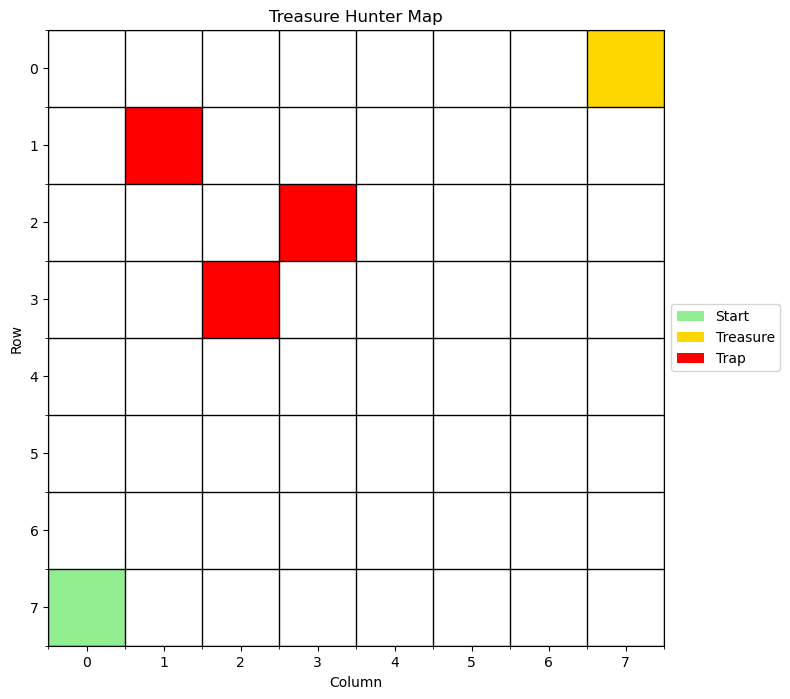

Episode 200: Avg Reward = 60.92, Avg Steps = 25.08, ε = 0.271
Episode 400: Avg Reward = 82.20, Avg Steps = 18.80, ε = 0.244
Episode 600: Avg Reward = 81.69, Avg Steps = 17.81, ε = 0.221
Episode 800: Avg Reward = 83.30, Avg Steps = 17.70, ε = 0.199
Episode 1000: Avg Reward = 83.71, Avg Steps = 17.29, ε = 0.180

Let's see how our hunter learned:


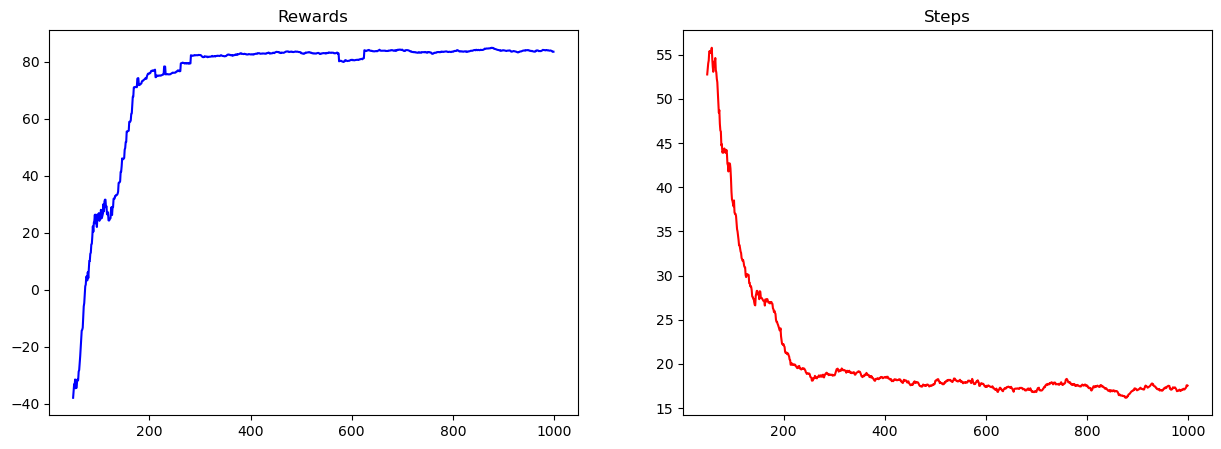


Testing our trained treasure hunter:

Best path found in 14 steps with reward 87!


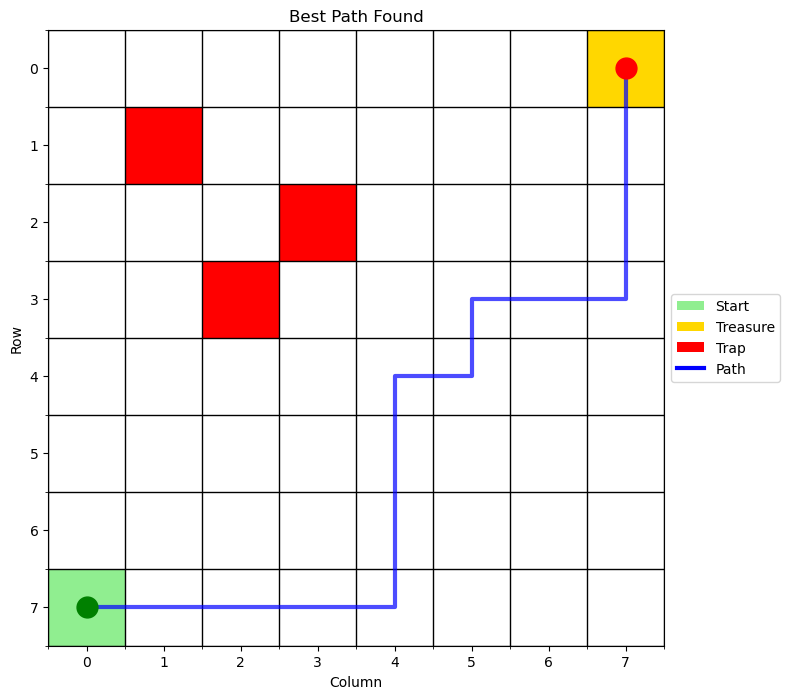


Here's what our hunter learned (Q-values):


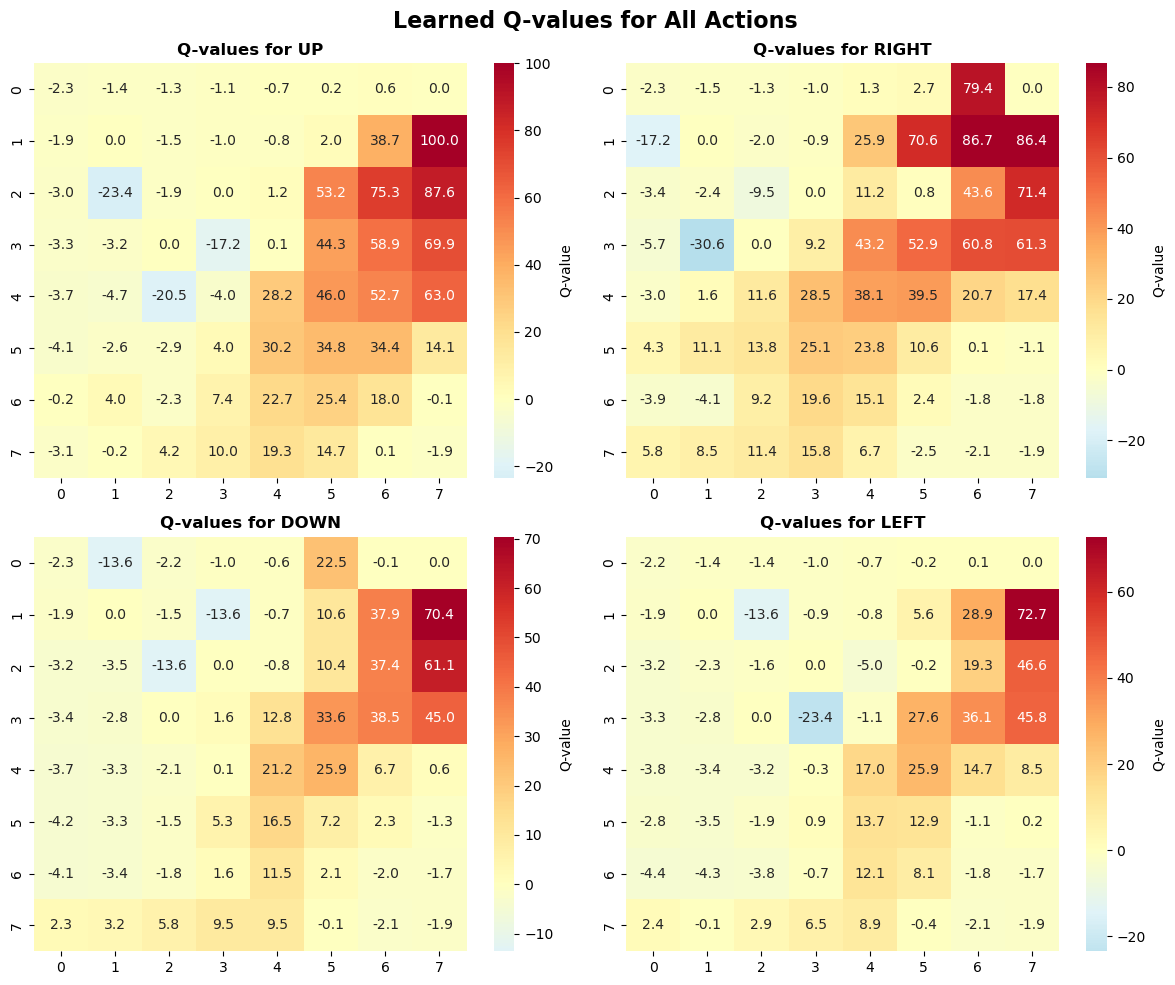

In [57]:
# trying with grid size of size 8 
demo_basic_sarsa(gsize = 8)

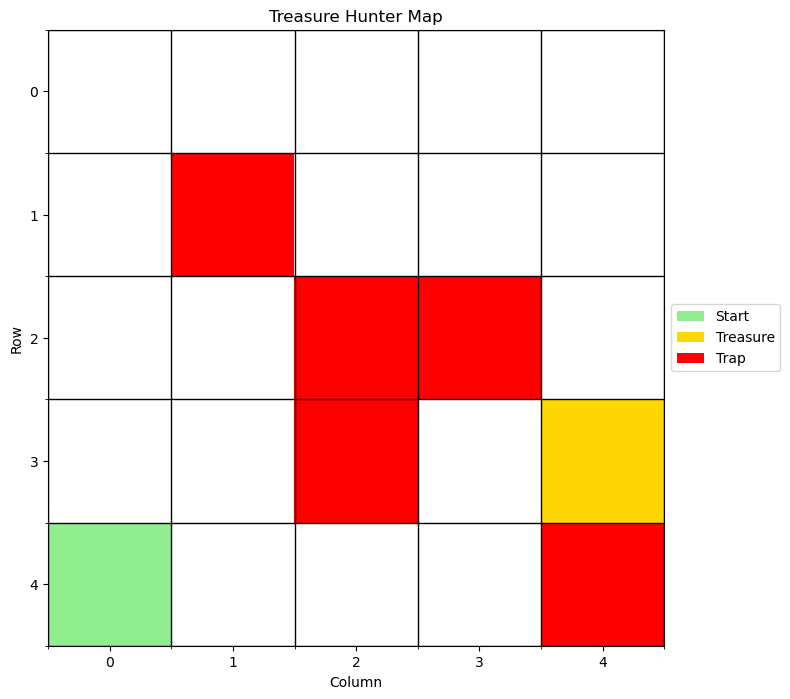

Episode 200: Avg Reward = 76.29, Avg Steps = 5.21, ε = 0.090
Episode 400: Avg Reward = 86.65, Avg Steps = 5.35, ε = 0.081
Episode 600: Avg Reward = 88.36, Avg Steps = 5.14, ε = 0.074
Episode 800: Avg Reward = 88.22, Avg Steps = 5.28, ε = 0.066
Episode 1000: Avg Reward = 79.38, Avg Steps = 5.12, ε = 0.060

Let's see how our hunter learned:


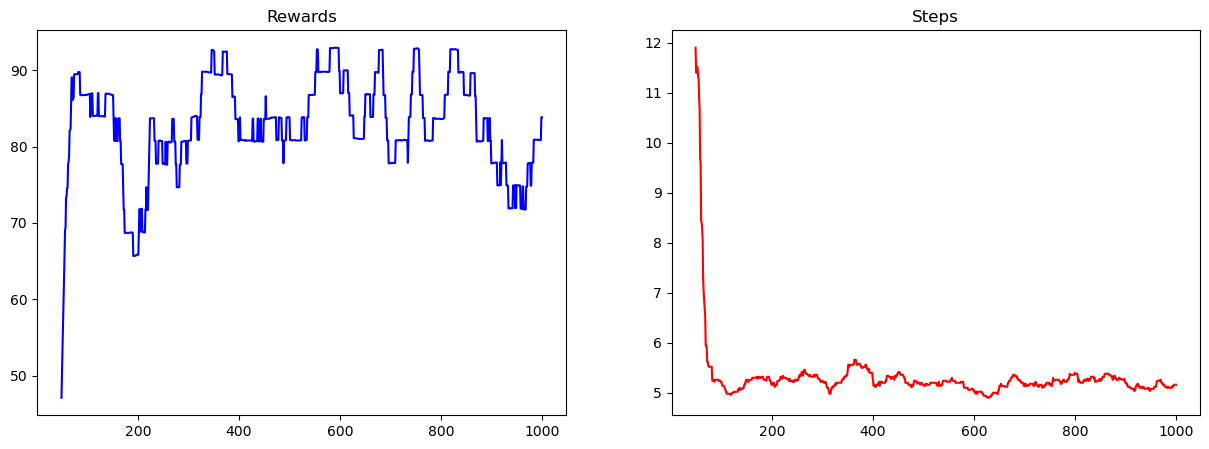


Testing our trained treasure hunter:

Best path found in 5 steps with reward 96!


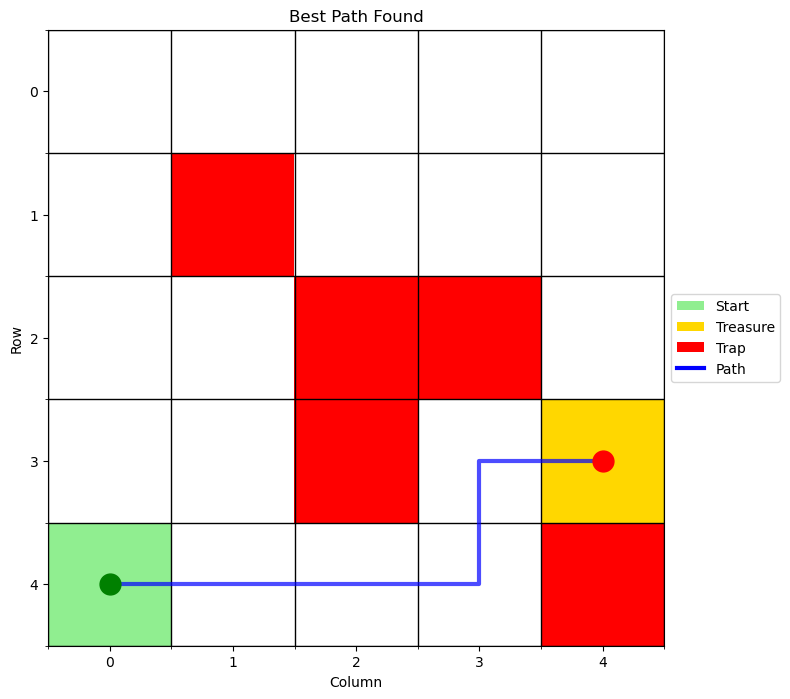

4

In [50]:
#changing the environment 

agent = TreasureHunterSARSA()
agent.traps.extend([ (2,2) , (4,4) ])
agent.treasure_pos = (3,4) 
agent.visualize_grid(title="Treasure Hunter Map")
agent.train(episodes=1000, policy='epsilon_greedy')

print("\nLet's see how our hunter learned:")
agent.visualize_learning_progress()

print("\nTesting our trained treasure hunter:")
test_results = agent.test_policy('greedy', num_tests=3)

best_result = min(test_results, key=lambda x: x[1])
print(f"\nBest path found in {best_result[1]} steps with reward {best_result[0]}!")
agent.visualize_grid(path=best_result[2], title="Best Path Found")
4


Episode 200: Avg Reward = 63.27, Avg Steps = 18.23, ε = 0.090
Episode 400: Avg Reward = 74.26, Avg Steps = 10.24, ε = 0.081
learning rate  :  0.01


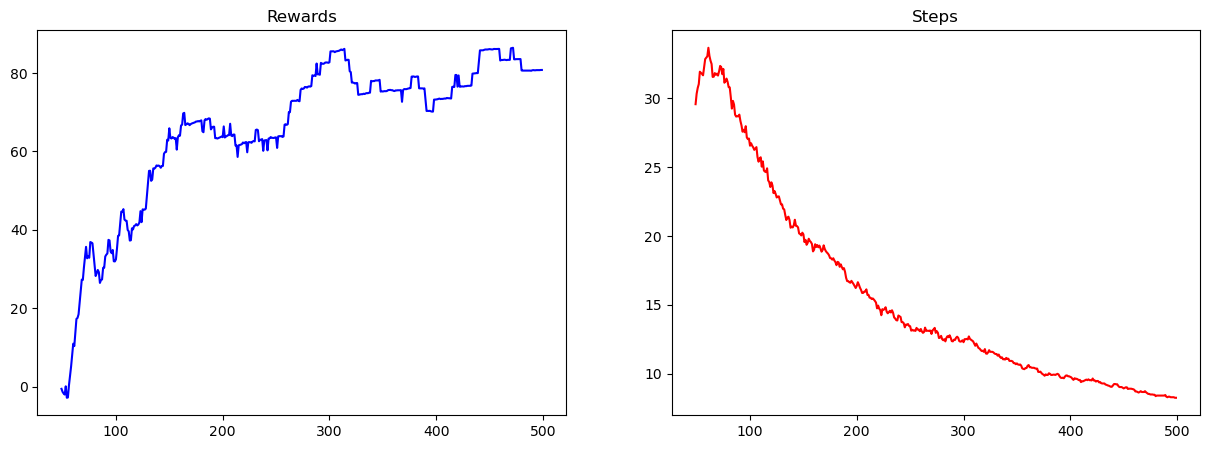

Episode 200: Avg Reward = 85.07, Avg Steps = 8.43, ε = 0.090
Episode 400: Avg Reward = 80.59, Avg Steps = 8.41, ε = 0.081
learning rate  :  0.1


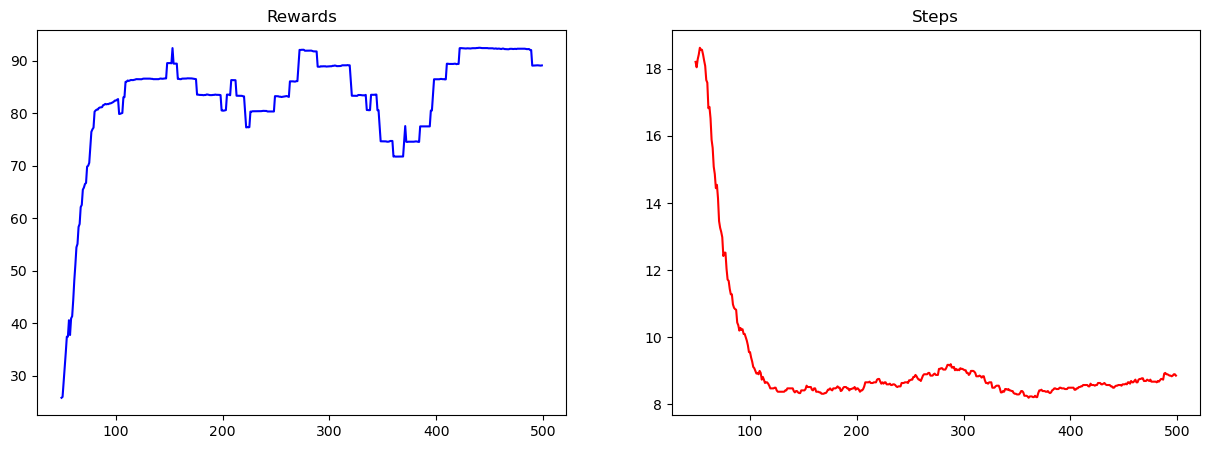

Episode 200: Avg Reward = 84.47, Avg Steps = 11.51, ε = 0.090
Episode 400: Avg Reward = 72.17, Avg Steps = 14.78, ε = 0.081
learning rate  :  0.5


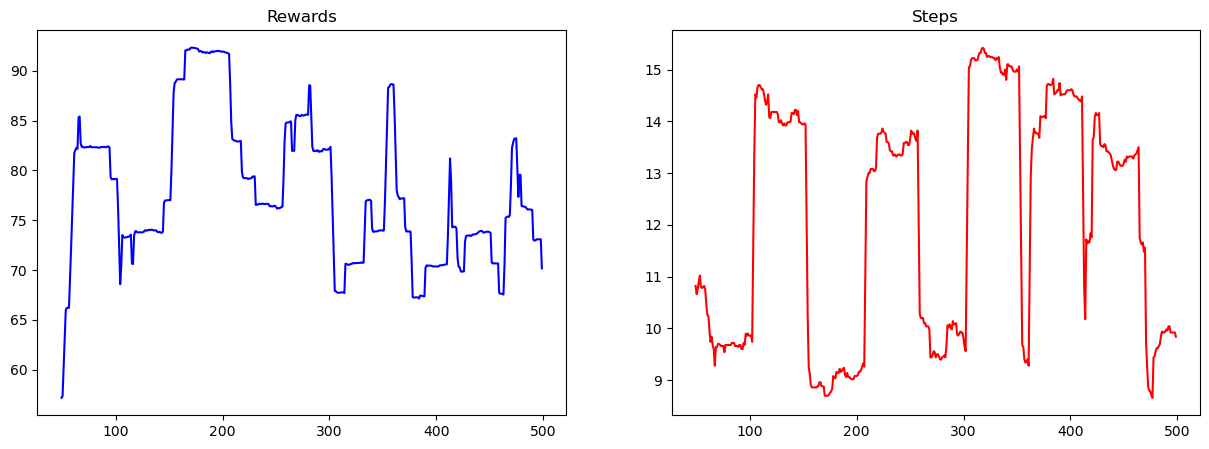

Episode 200: Avg Reward = 66.94, Avg Steps = 21.51, ε = 0.090
Episode 400: Avg Reward = 16.90, Avg Steps = 34.45, ε = 0.081
learning rate  :  0.9


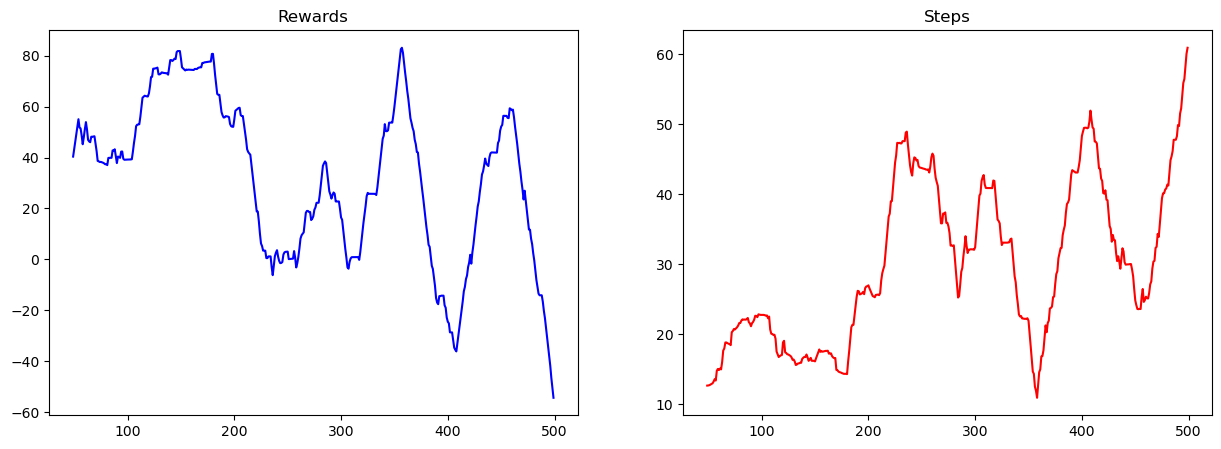

In [58]:
# testing the learning rate of alpha 
for lr in [0.01,0.1,0.5,0.9]:
    agent = TreasureHunterSARSA(alpha = lr)
    agent.train(episodes=500, policy='epsilon_greedy')
    print("learning rate  : " , lr) 
    agent.visualize_learning_progress()
    
    
    

Episode 200: Avg Reward = 87.82, Avg Steps = 8.68, ε = 0.090
Episode 400: Avg Reward = 88.00, Avg Steps = 8.50, ε = 0.081
Discount Factor  :  0.5


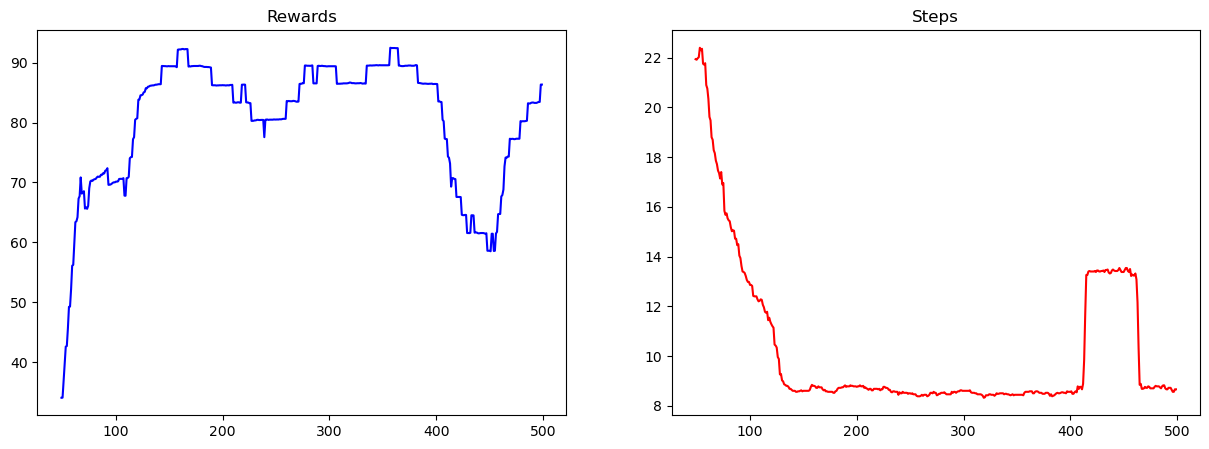

Episode 200: Avg Reward = 79.09, Avg Steps = 8.41, ε = 0.090
Episode 400: Avg Reward = 83.60, Avg Steps = 8.40, ε = 0.081
Discount Factor  :  0.8


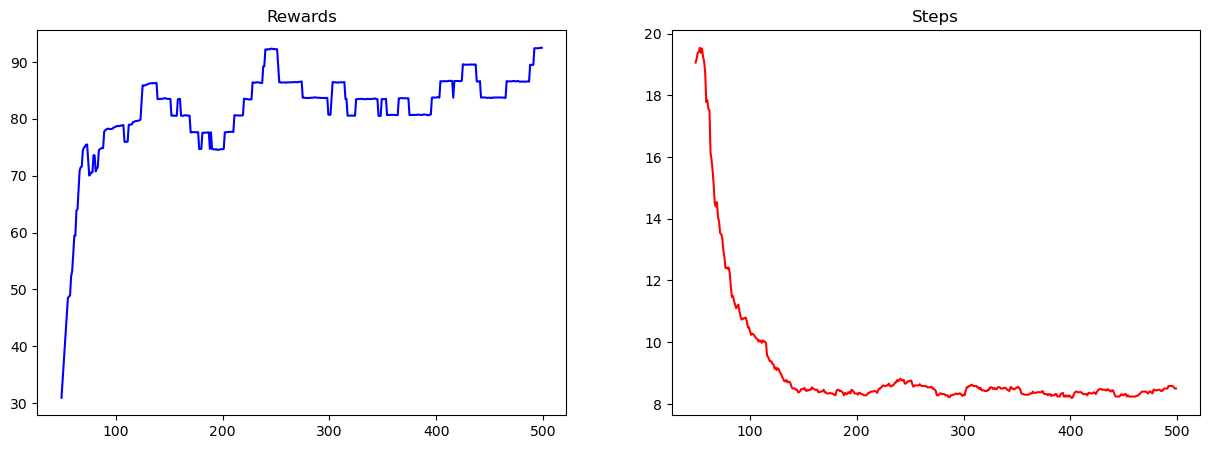

Episode 200: Avg Reward = 86.27, Avg Steps = 8.73, ε = 0.090
Episode 400: Avg Reward = 87.87, Avg Steps = 8.63, ε = 0.081
Discount Factor  :  0.9


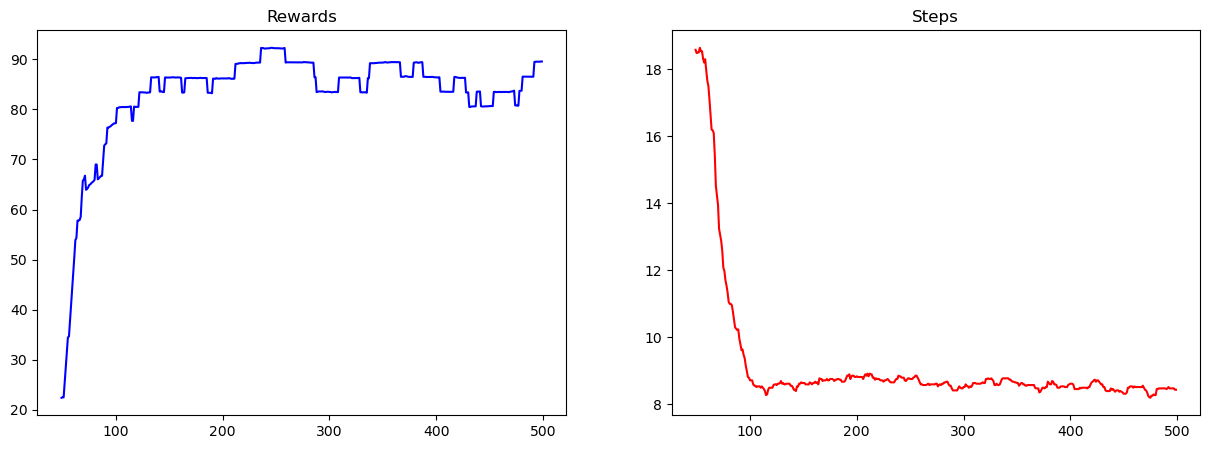

Episode 200: Avg Reward = 83.60, Avg Steps = 8.40, ε = 0.090
Episode 400: Avg Reward = 86.50, Avg Steps = 8.50, ε = 0.081
Discount Factor  :  0.99


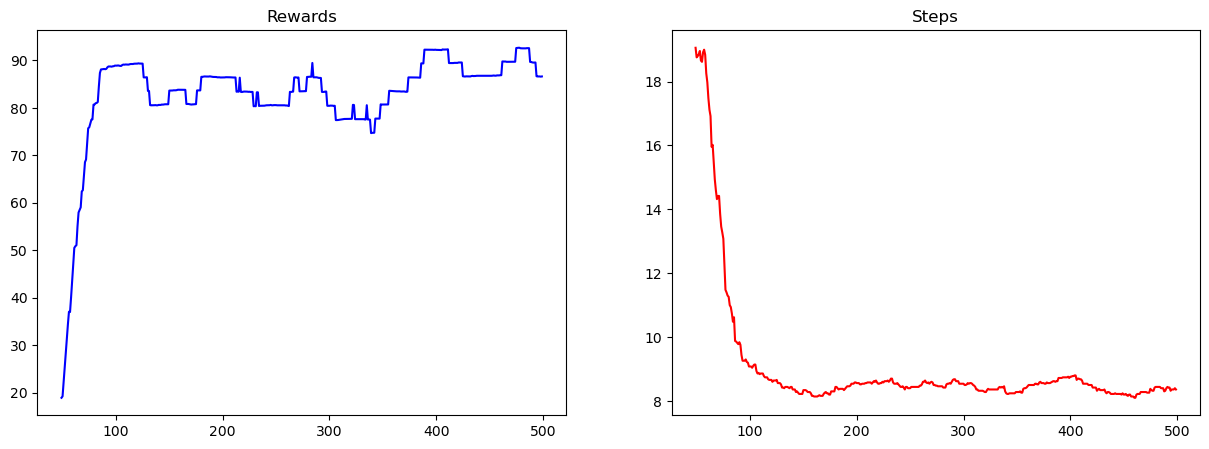

In [52]:
#testing the gamma parameter 
for g in [0.5, 0.8, 0.9, 0.99]:
    agent = TreasureHunterSARSA(gamma = g)
    agent.train(episodes=500, policy='epsilon_greedy')
    print("Discount Factor  : " , g) 
    agent.visualize_learning_progress()
    

In [59]:
demo_policy_comparison()


POLICY BATTLE ARENA!
Let's see which policy performs best!


Training with epsilon_greedy policy...
epsilon_greedy: Avg Reward = 93.0 (±0.0), Success Rate = 100.0%

Training with boltzmann policy...
boltzmann: Avg Reward = 93.0 (±0.0), Success Rate = 100.0%

Training with greedy policy...
greedy: Avg Reward = 93.0 (±0.0), Success Rate = 100.0%

Training with ucb policy...
ucb: Avg Reward = 93.0 (±0.0), Success Rate = 100.0%

Training with rank policy...
rank: Avg Reward = 93.0 (±0.0), Success Rate = 100.0%

THE WINNER IS: EPSILON GREEDY!
Success Rate: 100.0%
Average Reward: 93.0


In [60]:
def test_policy(self, policy='greedy', num_tests=5):
    print(f"\n Testing learned policy ({policy})...") 
    original_epsilon = self.epsilon 
    test_results = []  
    for test in range(num_tests): 
        if policy == 'greedy': 
            self.epsilon = 0  # No exploration during testing 
            reward, steps, path = self.run_episode(policy) 
            test_results.append((reward, steps, path)) 
            print(f"Test {test + 1}: Reward = {reward}, Steps = {steps}") 
    self.epsilon = original_epsilon  # Restore original epsilon 
    return test_results

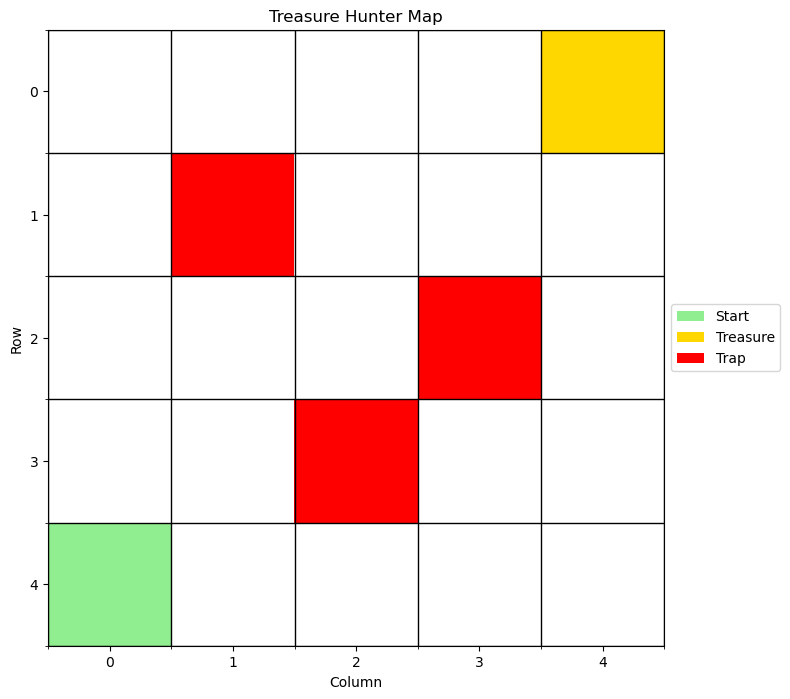

Episode 200: Avg Reward = 93.00, Avg Steps = 8.00, ε = 0.100
Episode 400: Avg Reward = 93.00, Avg Steps = 8.00, ε = 0.100
Episode 600: Avg Reward = 93.00, Avg Steps = 8.00, ε = 0.100
Episode 800: Avg Reward = 93.00, Avg Steps = 8.00, ε = 0.100
Episode 1000: Avg Reward = 93.00, Avg Steps = 8.00, ε = 0.100

Let's see how our hunter learned:


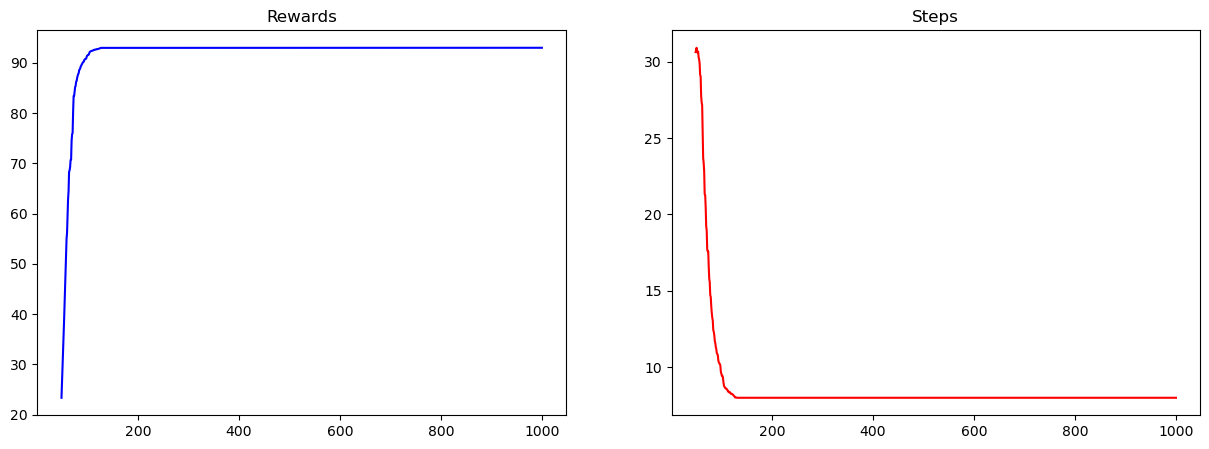


Testing our trained treasure hunter:

Best path found in 8 steps with reward 93!


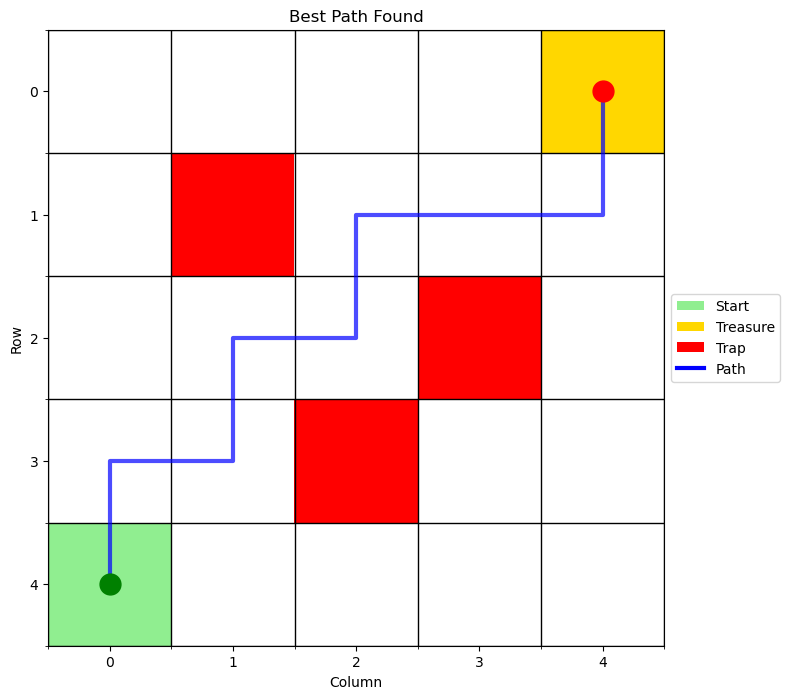

In [62]:
# trying sarsa with softmax policy 
agent = TreasureHunterSARSA()
agent.visualize_grid(title="Treasure Hunter Map")
agent.train(episodes=1000, policy='boltzmann')

print("\nLet's see how our hunter learned:")
agent.visualize_learning_progress()

print("\nTesting our trained treasure hunter:")
test_results = agent.test_policy('greedy', num_tests=3)

best_result = min(test_results, key=lambda x: x[1])
print(f"\nBest path found in {best_result[1]} steps with reward {best_result[0]}!")
agent.visualize_grid(path=best_result[2], title="Best Path Found")

